<a href="https://colab.research.google.com/github/Mathieu-Putz/Playing-with-PINNs/blob/main/3_PDE_1D_Diffusion.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import torch.nn as nn
import random
import matplotlib.pyplot as plt
import numpy as np  
import sympy as sy
from mpl_toolkits import mplot3d
from matplotlib import cm
from matplotlib.ticker import LinearLocator

# 3. First PDE: 1D Diffusion

Let's now try our hand at the diffusion equation in one spatial dimension. Let's imagine a thin tube stretching from x=-1 to x=1. At t=0, a gas is spread through the tube, such that its concentration is given by the function f(x) = 1-x^2. I.e. there is a maximum at x=0 and at both ends of the tube, the concentration is 0. Furthermore, let's impose the condition that the concentration at both ends be zero for all t. 

(Whether these are realistic boundary conditions is not of the essence for now.)

If we choose the right units, the diffusion will follow this PDE:

du/dt = d^2 u / dx^2

And the boundary conditions as described above are:

u(x,t=0) = f(x) = 1-4*(x-0.5)^2

u(0,t) = u(1, t) = 0

Again the analytical solution is known and we can use it to simulate gathering datapoints at random points. However, the exact solution is quite complicated and involves an infinite sum. I will only use the first 10 terms and I will not write out the full form here.


In [2]:
if torch.cuda.is_available():
    print(torch.cuda.get_device_name(0))
    device = torch.device('cuda')
else:
    device = torch.device('cpu')
print(device)

Tesla T4
cuda


In [3]:
# I will slightly modify the naming schemes relative to previous sections

# Number of datapoints
n = 20

# time domain from 0 to:
t_dom = 0.3

# random timepoints:
t = np.random.rand((n))*t_dom
t.sort()

# random points in the tube:
x = np.random.rand((n))

# random points in the tube at random time, in chronological order
# first col: time; second col: position
# m_pts for measurement points
m_pts = torch.Tensor([t,x]).T
m_pts = m_pts.to(device)

In [4]:
x_dummy = sy.Symbol("x_dummy")
f = lambda y : 1 - 4*((y-0.5)**2)
b = lambda y ,m : 2*sy.integrate(g(y,m), (y,0,1))

def g(x_dummy, m):
  return f(x_dummy)*sy.sin(m*np.pi*x_dummy*1.0)

# The correct solution involves the sum of an infinite series. The following
# variable indicates how many terms of that sum we calculate:
terms = 5

# This is the function we will try to approximate:
def h(pts):
  h = 0
  for n in range(1,terms+1):
    B = b(x_dummy, n)
    B = float(B)
    h = h + B*torch.sin(n* np.pi * pts[:,1]) * torch.exp(- n**2 * np.pi**2* pts[:,0])
  return h

# Get datapoints u
u = h(m_pts)
u = u.to(device)

In [5]:
# In this example we have two distinct boundaries, 
#  one for the value (0) at both ends of the tube, (b_x)
#  the other for the value (f(x)) at t=0. (b_t)

# We will sample random points from these boundaries and then force them to 
#  approximate the boundary conditions by including corresponding error terms in 
#  our loss function.
# Note that in reality, boundary points are virtually free, whereas datapoints 
#  are costly, which is why we will err on the side of having a lot of boundary 
#  points.
n_b_t = 200 # number of time boundary points
n_b_x = 2*300

b_t     = torch.tensor([np.zeros(n_b_t),np.random.rand(n_b_t)]).T
b_t, _  = torch.sort(b_t,0)
b_x_1   = torch.tensor([np.random.rand(n_b_x//2), np.zeros(n_b_x//2)]).T
b_x_2   = torch.tensor([np.random.rand(n_b_x//2), np.ones(n_b_x//2)]).T
b_x     = torch.cat((b_x_1, b_x_2))
#b_x, _  = torch.sort(b_x,0)


#comment out to run on cpu:
b_t = b_t.to(device)
b_x = b_x.to(device)

print(b_t.shape) #torch.Size([300, 2])
print(b_x.shape) #torch.Size([600, 2])

torch.Size([200, 2])
torch.Size([600, 2])


In [6]:
b_t_val = f(b_t[:,1])
b_x_val = torch.zeros((n_b_x))

#comment out to run on cpu:
b_t_val = b_t_val.to(device)
b_x_val = b_x_val.to(device)

In [7]:
#print(b_t)
#print(b_t_val)

In [8]:
# Define the Neural Network:
model = nn.Sequential(
          nn.Linear(2, 20), 
          nn.ReLU(), 
          nn.Linear(20,200),
          nn.ReLU(),
          nn.Linear(200,20), 
          nn.ReLU(),
          nn.Linear(20,1),
)
model = model.to(device)

learning_rate = 1e-4
lambda_t = 1
lambda_x = 1

# Loss function modified to take both boundaries into account
# add lambda parameters for weight of different losses
def loss(m_pts, b_t, b_x, u, b_t_val, b_x_val,lambda_t, lambda_x):
  u_pred = model(m_pts)
  u_pred = u_pred.squeeze()
  u_pred_b_t  = model(b_t.float())
  u_pred_b_t  = u_pred_b_t.squeeze()
  u_pred_b_x  = model(b_x.float())   
  u_pred_b_x  = u_pred_b_x.squeeze()
  return torch.mean((u_pred - u)**2) \
          + lambda_t* torch.mean((u_pred_b_t - b_t_val)**2)  \
          + lambda_x* torch.mean((u_pred_b_x - b_x_val)**2)

# Optimize
optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)

# Run the optimizer
def closure():
  optimizer.zero_grad()
  l = loss(m_pts, b_t, b_x, 
              u, b_t_val, b_x_val,
             lambda_t, lambda_x)
  l.backward()
  return l


for i in range(1500):
  optimizer.step(closure)
  if i%300 ==0:
    print(i, ": ", loss(m_pts, b_t, b_x, 
              u, b_t_val, b_x_val,
             lambda_t, lambda_x))

0 :  tensor(0.5534, device='cuda:0', dtype=torch.float64, grad_fn=<AddBackward0>)
300 :  tensor(0.2297, device='cuda:0', dtype=torch.float64, grad_fn=<AddBackward0>)
600 :  tensor(0.1107, device='cuda:0', dtype=torch.float64, grad_fn=<AddBackward0>)
900 :  tensor(0.0284, device='cuda:0', dtype=torch.float64, grad_fn=<AddBackward0>)
1200 :  tensor(0.0081, device='cuda:0', dtype=torch.float64, grad_fn=<AddBackward0>)


This is the 'exact' solution we're trying to approximate:


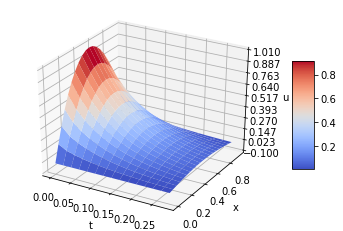

In [9]:
#fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
fig = plt.figure()
ax = plt.axes(projection='3d')
# Make data.
t_plot = np.arange(0, t_dom, 0.02)
x_plot = np.arange(0, 1, 0.05)
t_plot, x_plot = np.meshgrid(t_plot, x_plot)

U_2d = 0
for n in range(1,terms+1):
  B = b(x_dummy, n)
  B = float(B)
  U_2d = U_2d + B*np.sin(n* np.pi * x_plot) * np.exp(- n**2 * np.pi**2* t_plot)

print("This is the 'exact' solution we're trying to approximate:")

# Plot the surface.
surf = ax.plot_surface(t_plot, x_plot, U_2d, cmap=cm.coolwarm)

# Customize the z axis.
ax.set_zlim(-0.1, 1.01)
ax.zaxis.set_major_locator(LinearLocator(10))
# A StrMethodFormatter is used automatically

# Add a color bar which maps values to colors.
fig.colorbar(surf, shrink=0.5, aspect=5)

ax.set_xlabel("t")
ax.set_ylabel("x")
ax.set_zlabel("u")

plt.show()

(100, 100) (100, 100)
This is the approximation generated by our neural network


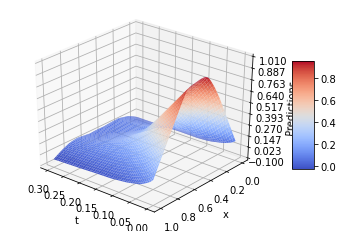

In [10]:
#fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
fig = plt.figure()
ax = plt.axes(projection='3d')

# Make data.
t_plot = np.linspace(0, t_dom, num=100)
x_plot = np.linspace(0, 1, num=100)

n_t = t_plot.size
n_x = x_plot.size

t_mesh, x_mesh = np.meshgrid(t_plot, x_plot)
print(t_mesh.shape, x_mesh.shape)

# Get predictions for these locations
# consider replacing for loop with meshgrid above
plot_pts = np.zeros((n_t*n_x,2))
for i in range(t_plot.size):
  for j in range(x_plot.size):
    plot_pts[i*x_plot.size+j,:] = [t_plot[i], x_plot[j]]

plot_pts_tensor = torch.tensor(plot_pts).float().to(device)

Predictions_2d = model(plot_pts_tensor)
Predictions_2d = Predictions_2d.detach().cpu().numpy()
Predictions_2d = Predictions_2d.reshape((n_t,n_x),order='F')

ax.view_init(30, 130)
print("This is the approximation generated by our neural network")
# Plot the surface.
surf = ax.plot_surface(t_mesh, x_mesh, Predictions_2d, cmap=cm.coolwarm)

# Customize the z axis.
ax.set_zlim(-0.1, 1.01)
ax.zaxis.set_major_locator(LinearLocator(10))
# A StrMethodFormatter is used automatically
#ax.zaxis.set_major_formatter('{x:.02f}')

# Add a color bar which maps values to colors.
fig.colorbar(surf, shrink=0.5, aspect=5)

ax.set_xlabel("t")
ax.set_ylabel("x")
ax.set_zlabel("Predictions")

plt.show()

This looks pretty good!

Again, all hyperparameters were chosen arbitrarily, nothing has been optimized. Nevertheless, we have a clear proof of concept.

# Evaluation

Now, let's evaluate our model on random points in the domain. Note that these points will be different from the random points used to train the model. We can think of the former as "test data" and the latter as "training data". 

Usually in a machine learning context, we would use the majority of our data for training. In this context however, data is actually free, since we have the analytical solution. We just want to pretend it's expensive.

Hence, it makes sense to use as little data as possible for training, but use a decent amount for testing. That way, we'll know how well our model actually performed when trained on only a small amount of data.

In [18]:
# Number of datapoints
n_eval = 3

# random timepoints:
t_eval = np.random.rand((n_eval))*t_dom
t_eval.sort()

# random points in the tube:
x_eval = np.random.rand((n_eval))

# random points in the tube at random time, in chronological order
# first col: time; second col: position
eval_pts = torch.Tensor([t_eval,x_eval]).T
eval_pts = eval_pts.to(device)

In [19]:
# ground truth
u_eval = h(eval_pts)
print(u_eval.shape)

torch.Size([3])


In [20]:
# predictions
pred_eval = model(eval_pts)
pred_eval = pred_eval.squeeze()

# MSE
MSE = torch.mean((u_eval-pred_eval)**2)

# Extra visualizations

Text(0.5, 0, 'u')

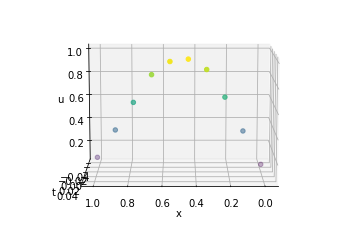

In [14]:
# Visualization of predictions at t=0

t_plot = np.zeros((10)) + 0
x_plot = np.linspace(0, 1, num=10)
t0_pts = torch.Tensor([t_plot,x_plot]).T.to(device)
pred_0 = model(t0_pts)

fig = plt.figure()
ax = plt.axes(projection='3d')

pred_0_graph = pred_0.detach().cpu().numpy()

ax.view_init(10, 90)
ax.scatter3D(x_plot, t_plot, \
             pred_0_graph, c=pred_0_graph)
ax.set_xlabel("x")
ax.set_ylabel("t")
ax.set_zlabel("u")

Below are some more visualizations of the training data and boundary values. They're not really relevant, but act as a sort of sanity check.

<class 'numpy.ndarray'> <class 'numpy.ndarray'> <class 'numpy.ndarray'>
(20,) (20,) (20,)


Text(0.5, 0, 'u')

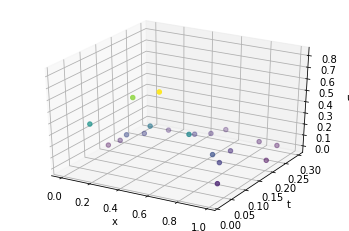

In [15]:
# Visualization of "datapoints"
#u_pred = model(m_pts)
#u_pred = u_pred.detach().numpy()
u_graph = u.cpu().detach().numpy()
#u_graph = np.zeros((50))
fig = plt.figure()
ax = plt.axes(projection='3d')
m_pts_x = m_pts[:,1]
m_pts_x = m_pts_x.cpu().detach().numpy()
m_pts_t = m_pts[:,0]
m_pts_t = m_pts_t.cpu().detach().numpy()
print(type(m_pts_x), type(m_pts_t),type(u_graph))
print(m_pts_x.shape, m_pts_t.shape, u_graph.shape)
ax.scatter3D(m_pts_x,  m_pts_t,\
             u_graph , c=u_graph)
ax.set_xlabel("x")
ax.set_ylabel("t")
ax.set_zlabel("u")

<class 'numpy.ndarray'> <class 'numpy.ndarray'> <class 'numpy.ndarray'>
(200,) (200,) (200,)


Text(0.5, 0, 'u')

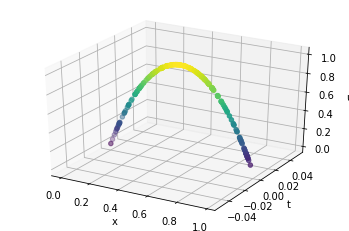

In [16]:
# Visualization of time boundary

b_t_val_plt = b_t_val.cpu().detach().numpy()
#u_graph = np.zeros((50))
fig = plt.figure()
ax = plt.axes(projection='3d')
# b_t_x means the x-coordinates of the constant time boundary (t=0)
b_t_x = b_t[:,1]
b_t_x = b_t_x.cpu().detach().numpy()
b_t_t = b_t[:,0]
b_t_t = b_t_t.cpu().detach().numpy()
print(type(b_t_x), type(b_t_t),type(b_t_val_plt))
print(b_t_x.shape, b_t_t.shape, b_t_val_plt.shape)
ax.scatter3D(b_t_x,  b_t_t,\
             b_t_val_plt , c=b_t_val_plt)
ax.set_xlabel("x")
ax.set_ylabel("t")
ax.set_zlabel("u")

<class 'numpy.ndarray'> <class 'numpy.ndarray'> <class 'numpy.ndarray'>
(600,) (600,) (600,)


Text(0.5, 0, 'u')

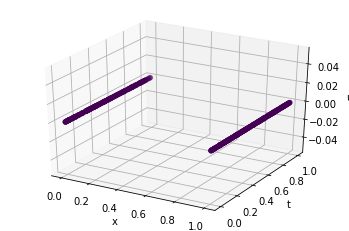

In [17]:
# Visualization of position boundary

b_x_val_plt = b_x_val.cpu().detach().numpy()
#u_graph = np.zeros((50))
fig = plt.figure()
ax = plt.axes(projection='3d')
# b_x_t means the t-coordinates of the position boundary (x=0 or x=1)
b_x_x = b_x[:,1]
b_x_x = b_x_x.cpu().detach().numpy()
b_x_t = b_x[:,0]
b_x_t = b_x_t.cpu().detach().numpy()
print(type(b_x_x), type(b_x_t),type(b_x_val_plt))
print(b_x_x.shape, b_x_t.shape, b_x_val_plt.shape)
ax.scatter3D(b_x_x,  b_x_t,\
             b_x_val_plt , c=b_x_val_plt)
ax.set_xlabel("x")
ax.set_ylabel("t")
ax.set_zlabel("u")